<a href="https://colab.research.google.com/github/rlagosb/taller_eiv/blob/main/2_Ejercicio_Normalizaci%C3%B3n_(R).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Normalización de datos

En este ejercicio vamos normalizar los datos de la demanda y la oferta de consultas de especialidad médica en el Servicio de Salud Metropolitano Sur Oriente en 2021. Vamos a  organizar los datos de manera eficiente para minimizar la redundancia y mejorar la integridad de los datos. Para ello es necesario:

1. Identificar las entidades y relaciones en un diagrama E-R
1. Normalizar datos de Demanda (interconsultas)
1. Normalizar datos de Especialidades
3. Normalizar datos de Oferta (producción, programación)

## Modelo Entidad-Relación

Primero es necesario tener un esquema de qué describen los datos e identificar las tablas necesarias. En este ejercicio podemos identificar as entidades:

- Centro de salud
- Especialidad
- Demanda (interconsultas)
- Producción histórica
- Programación


# Configurar área de trabajo

In [ ]:
#vemos paquetes ya instalados en colab
#installed.packages()[, "Package"]

In [ ]:
#borrar objetos previos
rm(list=ls())
#borrar figuras (si hay)
while(!dev.cur())dev.off()
cat("\014")

# Marcados con '#' es código que se computa. Queda como comentario

# para leer planillas y exportar .csvs
#if(!require("readr")) install.packages("readr", quiet=TRUE)
# para leer planillas excel
#if(!require("readxl")) install.packages("readxl", quiet=TRUE)
# para manipulación de datos
#if(!require("dplyr")) install.packages("dplyr", repos = "https://cran.rstudio.com/", quiet = TRUE)
library(dplyr)

# para archivos .parquet
if(!require("nanoparquet")) {
  install.packages("nanoparquet",
    dependencies = FALSE,
    repos = "https://packagemanager.posit.co/cran/latest",
    quiet=T)
}
# para escribir excels
if(!require("writexl")) {
  install.packages("writexl",
    dependencies = FALSE,
    repos = "https://packagemanager.posit.co/cran/latest",
    quiet=T)
}

# Definir carpetas de trabajo
datos_originales <- 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/data/'
datos_crudos <- 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/datos_crudos/'
datos_normalizados <- './datos_normalizados/'

# Crear carpetas
if (!dir.exists(datos_crudos)){dir.create(datos_crudos, recursive = TRUE)}
if (!dir.exists(datos_normalizados)){dir.create(datos_normalizados, recursive = TRUE)}

In [ ]:
# cargar datos
# --- SIC ---
dest_sic <- tempfile(fileext = ".parquet")
download.file(paste0(datos_crudos, "sic_2021_SSMSO.parquet"),
              dest_sic, mode = "wb", quiet = TRUE)
sic <- nanoparquet::read_parquet(dest_sic)
# --- Programación ---
dest_prog <- tempfile(fileext = ".parquet")
download.file(paste0(datos_crudos, "programacion_2021_SSMSO.parquet"),
              dest_prog, mode = "wb", quiet = TRUE)
programacion <- nanoparquet::read_parquet(dest_prog)
# --- Producción ---
dest_prod <- tempfile(fileext = ".parquet")
download.file(paste0(datos_crudos, "rem_A07_2021_SSMSO.parquet"),
              dest_prod, mode = "wb", quiet = TRUE)
produccion <- nanoparquet::read_parquet(dest_prod)

# 1- Normalizar demanda (solicitudes de interconsulta)

In [ ]:
# Examinemos la fuente de los datos de demanda
# ¿Cuáles campos son redundantes o innecesarios para nuestro análisis?
glimpse(sic) #resumen de los datos
# Configurar semilla para reproducibilidad
set.seed(123)
sic[sample(nrow(sic),5),] #tomamos 5 observaciones al azar

In [ ]:
#selecciono las columnas a continuación
demanda = sic[,c('PRESTA_MIN','F_ENTRADA','ESTAB_DEST')]
#ver la selección resultante
demanda

In [ ]:
# Usaremos sólo el mes y año y botaremos la fecha exacta de la interconsulta
  #primero definimos la columna año extrayéndola de la columna fecha entrada (F_ENTRADA)
  demanda$Año <- format(as.Date(demanda$F_ENTRADA), "%Y")
  #luego definimos la columna mes extrayéndola de la columna fecha entrada (F_ENTRADA)
  demanda$Mes <- format(as.Date(demanda$F_ENTRADA), "%m")
  #eliminamos la columna F_ENTRADA (fecha original) para reducir la información innecesaria
  demanda$F_ENTRADA <- NULL

In [ ]:
# Contar valores y reiniciar el índice
demanda <-
demanda %>%
  #contar observaciones
  dplyr::count(PRESTA_MIN, ESTAB_DEST, Año, Mes) %>%
  #renombrar las variables
  dplyr::rename(Interconsultas  = n,
                Especialidad    = PRESTA_MIN,
                Centro_destino  = ESTAB_DEST)

#visión preliminar de los datos
dplyr::glimpse(demanda)
#resumen de los datos
summary(demanda)
#muestra aleatoria de 5 observaciones
set.seed(123)
print(demanda[sample(nrow(demanda), 5), ])

In [ ]:
# Exportar a Datos Normalizados
nanoparquet::write_parquet(
    demanda,
    paste0(datos_normalizados, "Demanda.parquet")
)

## 🏁 Discusión

1. ¿Qué datos se perdieron al normalizar y agrupar los datos de demada?
2. ¿En qué incide?
3. Si más adelante necesitara incluir alguna de las variables que se perdieron, ¿qué tendría que hacer?

# 2- Normalizar especialidades

Debemos elegir un estándar para identificar las especialidades de las consultas médicas en nuestro análisis. Note que las solicitudes de interconsulta (sic) y la producción tienen distinta codificación.

In [ ]:
#Tres valores más frecuentes de la columna PRESTA_MIN en 'sic'
sic %>% dplyr::count(PRESTA_MIN, sort = TRUE) %>% head(3)

cat("\n\n") #saltos de línea

#Tres valores más frecuentes de la columna CodigoPrestacion en 'produccion'
produccion %>% dplyr::count(CodigoPrestacion, sort = TRUE) %>% head(3)

Debemos crear una tabla maestra **especialidades**.  Utilizaremos la [Norma Técnica 820 de Estándares de Información de Salud](https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/EstandaresNormativa/Decreto-Exento-643-Sustituye-Norma-T%C3%A9cnica-sobre-Est%C3%A1ndares-de-Informaci%C3%B3n-de-Salud-Actualizada-a-Dic-2016.pdf) en que están codificadas las especialidad de las interconsultas.

In [ ]:
# ruta al archivo remoto
url_excel <- paste0(
    datos_originales,
    "SS_MSOr_Respuesta%20Solicitud%20Folio%20AO012T0001655%20(CNE%202021).xlsx"
)

# descargar archivo temporalmente
destino <- tempfile(fileext = ".xlsx")
download.file(url_excel, destino, mode = "wb", quiet = TRUE)

# leer hoja "diccionario"
# Obtenemos el diccionario de códigos de especialidades
# médicas de las interconsultas
especialidades <- readxl::read_excel(
    path  = destino, #definimos ubicación del archivo
    sheet = "diccionario", #seleccionamos la hoja
    col_names = TRUE
) %>%
    #seleccionar las primeras dos columnas
    dplyr::select(Codigo = 1, Nombre = 2)%>%
    #seleccionamos las filas
    dplyr::slice(47:(47 + 67))

especialidades

## 🏁 Discusión
1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Cuál es el identificador (llave primaria) de una especialidad?
1. ¿Qué atributos tiene cada Especialidad?

## Agregar Especialidad_programacion
Ahora agregaremos la codificación de la Programación (que es la misma que la Producción) a la tabla Especialidades

In [ ]:
# URL al archivo Excel remoto
url_excel <- paste0(
    datos_originales,
    "programacion/114101_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx"
)
# descargar archivo Excel a un temporal
destino <- tempfile(fileext = ".xlsx")
download.file(url_excel, destino, mode = "wb", quiet = TRUE)
# leer hoja "Diccionarios"
# Creamos una tabla auxiliar con las especialidades
# de la programación
especialidades_prog <- readxl::read_excel(
        path  = destino,
        #seleccionamos la hoja Diccionario
        sheet = "Diccionarios",
        col_names = TRUE
    ) %>%
    # seleccionar las primeras dos columnas
    dplyr::select(
        Codigo_prog = 3,
        Nombre_prog = 2
    ) %>%
    #seleccionamos las filas
    dplyr::slice(
        2:(2 + 63)
    )
especialidades_prog

Para comparar las especialidades de dos fuentes de información necesitamos hacer un [JOIN](https://agscl.github.io/Est-Aplicada-UDP-2024/Clase4.html#11) (cruce) de tablas.

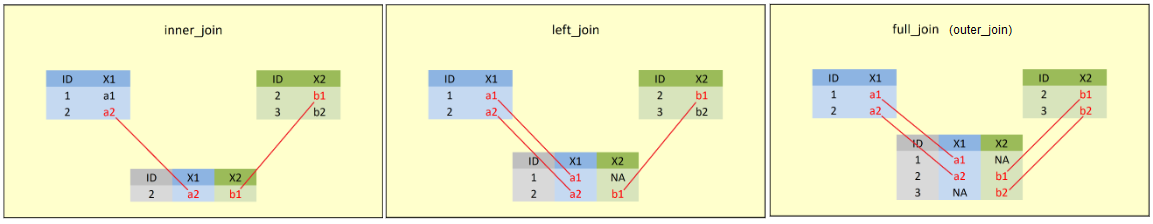


In [ ]:
# cruzamos ambos diccionarios y revisamos las especialidades
#sin match
# full join permite hacer el cruce de dos dataframes conservando
#los registros incompatibles de ambos
cruce <-
  especialidades %>%
  dplyr::full_join(especialidades_prog,
                 by = c("Nombre" = "Nombre_prog"),
                 keep = T) #by permite homologar las columnas
                 #"llave" de cada base que permiten unirlas
cruce

In [ ]:
# obtenemos las especialidades de programación que no coinciden
# observe que obtenemos los datos en formato array en vez de un dataframe
# Seleccionar los valores de Nombre_prog donde Nombre es NA
cruce$Nombre_prog[is.na(cruce$Nombre)]

#cruce['Nombre_prog'][cruce['Nombre'].isna()].array

In [ ]:
# obtenemos las especialidades 820 sin match
cruce$Nombre[is.na(cruce$Nombre_prog)]


In [ ]:
# homologamos a la norma 820 las especialidades de
#programación sin match
# por ej., el original CARDIOLOGÍA ADULTO lo adaptamos a
#CARDIOLOGÍA
match_especialidad <- c(
  "CARDIOLOGÍA ADULTO" = "CARDIOLOGÍA",
  "CIRUGÍA DIGESTIVA (ALTA)" = "CIRUGÍA DIGESTIVA",
  "CIRUGÍA GENERAL ADULTO" = "CIRUGÍA GENERAL",
  "CIRUGÍA PLÁSTICA Y REPARADORA ADULTO" = "CIRUGÍA PLÁSTICA Y REPARADORA",
  "CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA" = "CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA",
  "CIRUGÍA TÓRAX" = "CIRUGÍA DE TÓRAX",
  "COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)" = "COLOPROCTOLOGÍA",
  "ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)" = "ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)",
  "ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)" = "ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)",
  "GINECOLOGÍA ADULTO" = "GINECOLOGÍA",
  "HEMATO-ONCOLOGÍA INFANTIL" = "HEMATO-ONCOLOGÍA PEDIÁTRICA",
  "HEMATOLOGÍA ADULTO" = "HEMATOLOGÍA",
  "INFECTOLOGÍA ADULTO" = "INFECTOLOGÍA",
  "INFECTOLOGÍA PEDIÁTRICA" = "INFECTOLOGÍA PEDIATRICA",
  "LABORATORIO CLINICO" = "LABORATORIO CLÍNICO",
  "MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)" = "MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)",
  "MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)" = "MEDICINA FISICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRIA PEDIATRICA)",
  "MEDICINA INTENSIVA" = "MEDICINA INTENSIVA ADULTO",
  "MEDICINA NUCLEAR (EXCLUYE INFORMES)" = "MEDICINA NUCLEAR",
  "NEFROLOGÍA PEDIÁTRICA" = "NEFROLOGÍA PEDIÁTRICO",
  "NUTRIÓLOGO ADULTO" = "NUTRIÓLOGO",
  "REUMATOLOGÍA ADULTO" = "REUMATOLOGÍA",
  "TRAUMATOLOGÍA Y ORTOPEDIA ADULTO" = "TRAUMATOLOGÍA Y ORTOPEDIA",
  "UROLOGÍA ADULTO" = "UROLOGÍA"
)

# creamos un campo con las especialidades de la
#programación homologadas a la norma 820
cruce <- cruce %>%
  dplyr::mutate(Nombre_fix = recode(
    Nombre_prog,
    !!!match_especialidad, # Desempaquetamos el diccionario
    .default = Nombre_prog # Mantener valores no mapeados
  ))

# Revisamos las especialidades de programación y
#su nombre original y el homologado
cruce %>%
  dplyr::select(Codigo_prog, Nombre_prog, Nombre_fix) %>%
  filter(if_all(everything(), ~ !is.na(.)))

In [ ]:
# Agregamos el código de las especialidades de
#programación al maestro
# para ello cruzamos el maestro con las especialidades
#de programación homologadas
especialidades <- especialidades %>%
  dplyr::left_join( #unimos dejando especialidades
#como la base maestra (se conserva como está especialidades
#y sólo se agregan aquellos casos de la base cruce que
#coinciden con la llave de especialidades)
    na.omit( dplyr::select(cruce,
                       Codigo_prog,
                       Nombre_prog,
                       Nombre_fix) ), #de la base cruce,
                       #seleccionamos las 3 columnas de interés,
                       #y luego omitimos los perdidos de todas
                       #las columnas
    by = c("Nombre" = "Nombre_fix"),  #con qué llaves se unen
    keep= T #conservar ambas lalves
  )
especialidades

In [ ]:
# Eliminamos el campo que utilizamos para homologar ambos diccionarios
especialidades$Nombre_fix <- NULL

# Vemos el diccionario especialidades para nuestro análisis
especialidades

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
1. ¿Cuántas especialidades se programan en nuestra base de datos?

## Agregar especialidades REM

In [ ]:
# Obtenemos los códigos de las prestaciones del
#REM de consultas de especialidad
especialidades_rem <- produccion %>%
  # Seleccionamos la columna CodigoPrestacion
  dplyr::select(CodigoPrestacion) %>%
  # Eliminamos duplicados
  dplyr::distinct() %>%
  # Cambiamos el nombre de la columna
  dplyr::rename(Codigo_rem = CodigoPrestacion)

# Ver el resultado
especialidades_rem

In [ ]:
# Cruzamos las especialidades REM con las especialidades
#de programación del diccionario
cruce_rem <-
  especialidades %>%
  #cambiamos la clase de la variable para que
  #coincida con la de la base de datos "especialidades_rem"
  #ℹ `x$Codigo_prog` is a <character>.
  #ℹ `y$Codigo_rem` is a <double>.
    dplyr::mutate(Codigo_prog= as.numeric(Codigo_prog))%>%
  dplyr::full_join(especialidades_rem,
                 by = c("Codigo_prog" = "Codigo_rem"),
                 keep = T) #by permite homologar las
                 #columnas "llave" de cada base que permiten
                 #unirlas

# Vemos el resultado
cruce_rem

In [ ]:
# ¿Qué prestaciones REM no son homologables al maestro de especialidades?
cruce_rem[is.na(cruce_rem$Codigo), ]

In [ ]:
# Note que radioterapia oncológica si está en el diccionario, ¡pero con otro código!
especialidades[which(especialidades$Nombre_prog=='RADIOTERAPIA ONCOLÓGICA'),] #buscamos en la base de datos, la fila (por eso los argumentos van a la izquierda de la coma dentro de las llaves [XXXXXX,]), en que el vector Nombre_prog de la base especialidades coincide con 'RADIOTERAPIA ONCOLÓGICA'

In [ ]:
# Corregimos manualmente el Codigo REM de radioterapia oncológica en el cruce_rem
cruce_rem$Codigo_rem[cruce_rem$Nombre_prog == "RADIOTERAPIA ONCOLÓGICA"] <- 7030500 # para la columna Codigo_rem, tomamos los elementos cuyos valores de Nombre_prog coinciden con  "RADIOTERAPIA ONCOLÓGICA" y los reemplazamos con el código 7030500

# Vemos el resultado
cruce_rem[cruce_rem$Nombre_prog == "RADIOTERAPIA ONCOLÓGICA", ] #ahora vemos las filas de la base de datos cruce_rem en que la columna Nombre_prog coincide con "RADIOTERAPIA ONCOLÓGICA"

In [ ]:
# Agregamos el código REM al maestro de especialidades
especialidades <- especialidades %>%
  dplyr::left_join(na.omit(cruce_rem[, c("Codigo", "Codigo_rem")]), #de la base cruce_rem, de la que también seleccionamos las columnas "Codigo" y "Codigo_rem", eliminamos todas las observaciones (filas) que contengan al menos un NA
            by = "Codigo") #unimos las bases por una
            #llave común llamada Codigo

# Vemos el resultado
especialidades

In [ ]:
# Agregamos el diccionario a la base de datos normalizados
writexl::write_xlsx(
    especialidades,
    paste0(datos_normalizados, "Especialidades.xlsx")
)


### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
3. ¿Qué significa que una especialidad del diccionario no tenga código REM o de programación? ¿Es una inconsistencia?
2. ¿Qué pasa si una especialidad no tiene código norma 820? ¿Es una inconsistencia?

# 🍎 Desafío 1: Normalizar Producción

1. Obtenga los datos REM (```rem_A07_2021_SSMSO.parquet```) de la carpeta de *datos_crudos* y examine la información que contiene
2. Genere un dataframe con las columnas:
  - Año
  - Mes
  - IdEstablecimiento
  - CodigoPrestacion
  - ConsultasTotales (utilice los datos de `Col1`)
  - ConsultasNuevas (utilice `Col22 + Col26`)
  - Controles (`ConsultasTotales - ConsultasNuevas`)
3. Codifique las prestaciones con la norma 820. Para ello:
  - Cambie el nombre de *CodigoPrestacion* por *Codigo_rem*
  - Agrege el campo *Especialidad* de la tabla *Especialidades* con un *Join* en base al campo *Codigo_rem*
  - Elimine el campo *Codigo_rem*
4. Guarde el dataframe resultante en la carpeta *datos_normalizados*

# 🍎 Desafío 2: Normalizar Programación

Cargamos los datos

In [ ]:
#@title Extraer datos fichas (R code)

path_fichas <- "https://raw.githubusercontent.com/rlagosb/taller_eiv/main/data/programacion/Fichas/"
planilla_fichas <- "Fichas Unidad Endoscopia.xlsx"

# Descargar el archivo (cambiamos espacios por caracteres
#Unicode (%20) o HTML-friendly)
url_completa <- paste0(path_fichas, gsub(" ","%20",planilla_fichas))
destino_excel <- tempfile(fileext = ".xlsx")

download.file(url_completa, destino_excel, mode = "wb", quiet = TRUE)

message(paste0('Planilla ', planilla_fichas, ' descargada ✅'))
ls()

programacion_desde_fichas_slots <- function(destino_excel, #archivo
                                            skip= 6, #desde qué fila empieza la tabla horaria
                                            start_time = "07:00", #hora de inicio
                                            step_minutes = 30) { #qué representa cada celda (en tiempo)
  #importamos el archivo
  archivo <- destino_excel

  # --- lee 1 celda seguro (si está vacía -> NA)
  leer_celda <- function(path, sheet, range) {
    x <- suppressMessages(
      readxl::read_excel(path, sheet = sheet, range = range,
                        col_names = FALSE, .name_repair = "minimal")
    )
    if (nrow(x) == 0 || ncol(x) == 0) return(NA)
    x[[1]][1]
  }

  # --- normaliza texto para nombres
  norm_txt <- function(x) {
    x <- trimws(as.character(x))
    x <- tolower(x)
    y <- suppressWarnings(iconv(x, to = "ASCII//TRANSLIT"))
    ifelse(is.na(y), x, y)
  }

  # --- HH:MM -> minutos
  hhmm_to_min <- function(hhmm) {
    hhmm <- trimws(as.character(hhmm))
    hhmm <- gsub("[^0-9:]", "", hhmm)
    parts <- strsplit(hhmm, ":", fixed = TRUE)[[1]]
    if (length(parts) < 2) return(NA_real_)
    hh <- suppressWarnings(as.numeric(parts[1]))
    mm <- suppressWarnings(as.numeric(parts[2]))
    if (is.na(hh) || is.na(mm)) return(NA_real_)
    hh * 60 + mm
  }

  # --- minutos -> HH:MM
  min_to_hhmm <- function(m) {
    m <- round(m) %% 1440
    sprintf("%02d:%02d", m %/% 60, m %% 60)
  }

  # --- Hojas
  # excluimos las que no representan horarios del personal
  hojas_exclude <- c("Personal", "Prestaciones", "Ficha Programación")
  hojas_fichas <- setdiff(readxl::excel_sheets(archivo), hojas_exclude)
  cat("Procesando:", paste(hojas_fichas, collapse = ", "), "\n")

  start_min <- hhmm_to_min(start_time)
  if (is.na(start_min)) stop("start_time debe ser 'HH:MM' (ej. '07:00').")

  fichas_list <- list()

  for (hoja in hojas_fichas) {

    # Metadata profesional
    nombre <- leer_celda(archivo, hoja, "C3")
    rut <- as.character(leer_celda(archivo, hoja, "C4"))
    profesion <- leer_celda(archivo, hoja, "C5")
    hrs_contrato <- suppressWarnings(as.numeric(leer_celda(archivo, hoja, "F3")))
    hrs_prog_total <- suppressWarnings(as.numeric(leer_celda(archivo, hoja, "F4")))
    obs <- leer_celda(archivo, hoja, "F5")

    # Lee tabla desde fila 7 (skip=6) como venías haciendo
    raw <- suppressMessages(
      readxl::read_excel(archivo, sheet = hoja, skip = skip,
                         col_names = FALSE, .name_repair = "minimal")
    )

    if (nrow(raw) == 0 || ncol(raw) < 3) {
      cat(hoja, " (sin tabla) ✖\n")
      next
    }

    # Quita columnas iniciales completamente vacías (si existieran)
    while (ncol(raw) > 0) {
      c1 <- raw[[1]]
      c1_chr <- trimws(as.character(c1))
      if (all(is.na(c1) | c1_chr == "")) raw <- raw[, -1, drop = FALSE] else break
    }
    if (ncol(raw) < (skip+1)) {
      cat(hoja, " (tabla incompleta) ✖\n")
      next
    }

    # Usa la primera fila como encabezado (Inicio, Término, Lunes...)
    header <- norm_txt(unlist(raw[1, ], use.names = FALSE))
    header[is.na(header) | header == ""] <- paste0("v", which(is.na(header) | header == ""))
    header <- make.unique(header, sep = "_")
    names(raw) <- header
    raw <- raw[-1, , drop = FALSE]

    # Identifica columnas esperadas (siempre mismo formato)
    # Nota: 'termino' captura 'término' ya transliterado
    cols_need <- c("inicio", "termino", "lunes", "martes", "miercoles", "jueves", "viernes")
    missing_cols <- setdiff(cols_need, norm_txt(names(raw)))
    if (length(missing_cols) > 0) {
      cat(hoja, " (faltan columnas:", paste(missing_cols, collapse = ", "), ") ✖\n")
      next
    }

    # Reordena/selecciona exactamente esas 7 (por seguridad)
    # (match contra nombres normalizados)
    nms_norm <- norm_txt(names(raw))
    raw <- raw[, match(cols_need, nms_norm), drop = FALSE]
    names(raw) <- cols_need

    # Recorta filas al último slot con alguna actividad (evita cola vacía)
    day_mat <- raw[, c("lunes", "martes", "miercoles", "jueves", "viernes"), drop = FALSE]
    nonempty_row <- apply(day_mat, 1, function(r) {
      any(!is.na(r) & trimws(as.character(r)) != "")
    })
    if (!any(nonempty_row)) {
      cat(hoja, " (sin actividades) ✖\n")
      next
    }
    last_row <- max(which(nonempty_row))
    raw <- raw[seq_len(last_row), , drop = FALSE]

    # Slot discreto: 1 fila = 1 bloque fijo de step_minutes
    raw <- raw %>%
      dplyr::mutate(slot = dplyr::row_number())

    # Pivot manual (sin tidyr), usando slot
    dias <- c("lunes", "martes", "miercoles", "jueves", "viernes")
    prog_list <- list()
    for (j in seq_along(dias)) {
      d <- dias[j]
      prog_list[[j]] <- raw %>%
        dplyr::transmute(
          dia = j,
          dia_nom = d,
          slot = slot,
          actividad = as.character(.data[[d]])
        )
    }

    prog <- dplyr::bind_rows(prog_list) %>%
      dplyr::filter(!is.na(actividad) & trimws(actividad) != "")

    if (nrow(prog) == 0) {
      cat(hoja, " (sin actividades) ✖\n")
      next
    }

    # Une bloques contiguos IGUALES según slot (sin minutos)
    prog2 <- prog %>%
      dplyr::arrange(dia, slot) %>%
      dplyr::group_by(dia, dia_nom) %>%
      dplyr::mutate(
        act_lag = dplyr::lag(actividad),
        slot_lag = dplyr::lag(slot),
        cambio = is.na(act_lag) | (actividad != act_lag) | (slot != slot_lag + 1),
        grupo = cumsum(dplyr::coalesce(cambio, TRUE))
      ) %>%
      dplyr::ungroup() %>%
      dplyr::group_by(dia, dia_nom, actividad, grupo) %>%
      dplyr::summarise(
        slot_ini = min(slot),
        slot_fin = max(slot),
        n_slots = slot_fin - slot_ini + 1,
        .groups = "drop"
      ) %>%
      dplyr::mutate(
        ini = min_to_hhmm(start_min + (slot_ini - 1) * step_minutes),
        fin = min_to_hhmm(start_min + (slot_fin) * step_minutes),
        hrs = n_slots * step_minutes / 60,
        rut = rut, nombre = nombre, profesion = profesion,
        hrs_contrato = hrs_contrato, hrs_prog_total = hrs_prog_total,
        obs = obs, hoja = hoja
      ) %>%
      dplyr::select(
        rut, nombre, profesion, hrs_contrato, hrs_prog_total, obs, hoja,
        dia, dia_nom, ini, fin, actividad, hrs
      )

    fichas_list[[hoja]] <- prog2
    cat(hoja, "✔\n")
  }

  dplyr::bind_rows(fichas_list)
}


In [ ]:
programacion <- programacion_desde_fichas_slots(destino_excel)
programacion